In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/yawn-eye-dataset-new/dataset_new/test/Closed/_163.jpg
/kaggle/input/yawn-eye-dataset-new/dataset_new/test/Closed/_330.jpg
/kaggle/input/yawn-eye-dataset-new/dataset_new/test/Closed/_498.jpg
/kaggle/input/yawn-eye-dataset-new/dataset_new/test/Closed/_167.jpg
/kaggle/input/yawn-eye-dataset-new/dataset_new/test/Closed/_76.jpg
/kaggle/input/yawn-eye-dataset-new/dataset_new/test/Closed/_439.jpg
/kaggle/input/yawn-eye-dataset-new/dataset_new/test/Closed/_226.jpg
/kaggle/input/yawn-eye-dataset-new/dataset_new/test/Closed/_168.jpg
/kaggle/input/yawn-eye-dataset-new/dataset_new/test/Closed/_96.jpg
/kaggle/input/yawn-eye-dataset-new/dataset_new/test/Closed/_64.jpg
/kaggle/input/yawn-eye-dataset-new/dataset_new/test/Closed/_373.jpg
/kaggle/input/yawn-eye-dataset-new/dataset_new/test/Closed/_115.jpg
/kaggle/input/yawn-eye-dataset-new/dataset_new/test/Closed/_20.jpg
/kaggle/input/yawn-eye-dataset-new/dataset_new/test/Closed/_559.jpg
/kaggle/input/yawn-eye-dataset-new/dataset_new/test/

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

2024-04-02 04:28:19.676675: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-02 04:28:19.676805: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-02 04:28:19.954541: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
# Define InceptionV3 architecture
def InceptionV3(input_shape=(299, 299, 3), num_classes=1000):
    input_layer = tf.keras.layers.Input(shape=input_shape)

    # Stem
    x = conv2d_bn(input_layer, 32, 3, 3, strides=(2, 2), padding='valid')
    x = conv2d_bn(x, 32, 3, 3, padding='valid')
    x = conv2d_bn(x, 64, 3, 3)

    x1 = tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid')(x)
    x2 = conv2d_bn(x, 96, 3, 3, strides=(2, 2), padding='valid')
    x = tf.keras.layers.concatenate([x1, x2], axis=-1)

    x1 = conv2d_bn(x, 64, 1, 1)
    x1 = conv2d_bn(x1, 96, 3, 3, padding='valid')

    x2 = conv2d_bn(x, 64, 1, 1)
    x2 = conv2d_bn(x2, 64, 1, 7)
    x2 = conv2d_bn(x2, 64, 7, 1)
    x2 = conv2d_bn(x2, 96, 3, 3, padding='valid')

    x = tf.keras.layers.concatenate([x1, x2], axis=-1)

    x1 = conv2d_bn(x, 192, 3, 3, strides=(2, 2), padding='valid')
    x2 = tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid')(x)
    x = tf.keras.layers.concatenate([x1, x2], axis=-1)

    # Inception blocks
    for _ in range(3):
        branch1x1 = conv2d_bn(x, 64, 1, 1)

        branch5x5 = conv2d_bn(x, 48, 1, 1)
        branch5x5 = conv2d_bn(branch5x5, 64, 5, 5)

        branch3x3dbl = conv2d_bn(x, 64, 1, 1)
        branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)
        branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)

        branch_pool = tf.keras.layers.AveragePooling2D(pool_size=(3, 3), strides=(1, 1), padding='same')(x)
        branch_pool = conv2d_bn(branch_pool, 32, 1, 1)

        x = tf.keras.layers.concatenate([branch1x1, branch5x5, branch3x3dbl, branch_pool], axis=-1)

    # Auxiliary classifier 1
    auxiliary_output_1 = auxiliary_classifier(x, num_classes)

    # Inception blocks continued
    branch1x1 = conv2d_bn(x, 192, 1, 1)
    branch1x1 = conv2d_bn(branch1x1, 320, 3, 3, strides=(2, 2), padding='valid')

    branch3x3 = conv2d_bn(x, 192, 1, 1)
    branch3x3 = conv2d_bn(branch3x3, 192, 1, 7)
    branch3x3 = conv2d_bn(branch3x3, 192, 7, 1)
    branch3x3 = conv2d_bn(branch3x3, 192, 3, 3, strides=(2, 2), padding='valid')

    x = tf.keras.layers.concatenate([branch1x1, branch3x3], axis=-1)

    # Inception blocks continued
    for _ in range(2):
        branch1x1 = conv2d_bn(x, 320, 1, 1)

        branch7x7 = conv2d_bn(x, 192, 1, 1)
        branch7x7 = conv2d_bn(branch7x7, 192, 1, 7)
        branch7x7 = conv2d_bn(branch7x7, 192, 7, 1)
        branch7x7 = conv2d_bn(branch7x7, 192, 1, 7)
        branch7x7 = conv2d_bn(branch7x7, 192, 7, 1)

        branch7x7dbl = conv2d_bn(x, 192, 1, 1)
        branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 7, 1)
        branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 1, 7)
        branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 7, 1)
        branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 1, 7)
        branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 7, 1)

        branch_pool = tf.keras.layers.AveragePooling2D(pool_size=(3, 3), strides=(1, 1), padding='same')(x)
        branch_pool = conv2d_bn(branch_pool, 192, 1, 1)

        x = tf.keras.layers.concatenate([branch1x1, branch7x7, branch7x7dbl, branch_pool], axis=-1)

    # Final classification layer
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    output_layer = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(input_layer, [output_layer, auxiliary_output_1])
    return model

# Helper functions for building layers
def conv2d_bn(x, filters, num_row, num_col, padding='same', strides=(1, 1), name=None):
    x = tf.keras.layers.Conv2D(filters, (num_row, num_col), strides=strides, padding=padding, use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization(axis=3, scale=False)(x)
    x = tf.keras.layers.Activation('relu', name=name)(x)
    return x

def auxiliary_classifier(x, num_classes):
    x = tf.keras.layers.AveragePooling2D(pool_size=(5, 5), strides=3)(x)
    x = conv2d_bn(x, 128, 1, 1)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.7)(x)
    output_layer = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    return output_layer

# Usage example
num_classes = 1000
input_shape = (299, 299, 3)
model = InceptionV3(input_shape=input_shape, num_classes=num_classes)
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 149, 149,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 149, 149,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 149, 149,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 147, 147,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 147, 147,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 73, 73,    │     55,296 │ activation_2[0][… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 73, 73,    │        288 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 73, 73,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 73, 73,    │          0 │ batch_normalizat… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 73, 73,    │          0 │ max_pooling2d[0]… │
│ (Concatenate)       │ 160)              │            │ activation_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 73, 73,    │     10,240 │ concatenate[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 73, 73,    │        192 │ conv2d_6[0][0]  

 Total params: 26,683,296 (101.79 MB)

 Trainable params: 26,665,472 (101.72 MB)

 Non-trainable params: 17,824 (69.62 KB)

In [14]:
# Define data directories
train_dir = '/kaggle/input/yawn-eye-dataset-new/dataset_new/train'
test_dir = '/kaggle/input/yawn-eye-dataset-new/dataset_new/test'

In [15]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [16]:
batch_size = 32
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(299, 299),
    batch_size=batch_size,
    class_mode='categorical')



Found 2467 images belonging to 4 classes.


In [17]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(299, 299),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

Found 433 images belonging to 4 classes.


In [23]:
# Build and compile the model
num_classes = 4
model = InceptionV3(input_shape=(299, 299, 3), num_classes=num_classes)
# Compile the model with metrics for both outputs
model.compile(optimizer='adam',
              loss=['categorical_crossentropy', 'categorical_crossentropy'],
              metrics=['accuracy', 'accuracy'])

In [50]:
epochs = 50
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size)


Epoch 1/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 36s 455ms/step - dense_11_accuracy: 0.9642 - loss: 0.1273 - val_dense_11_accuracy: 0.5529 - val_loss: 1.5886
Epoch 2/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - dense_11_accuracy: 1.0000 - loss: 0.0214 - val_dense_11_accuracy: 0.7647 - val_loss: 0.9946
Epoch 3/50


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


77/77 ━━━━━━━━━━━━━━━━━━━━ 36s 457ms/step - dense_11_accuracy: 0.9783 - loss: 0.0666 - val_dense_11_accuracy: 0.8894 - val_loss: 0.2782
Epoch 4/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - dense_11_accuracy: 1.0000 - loss: 0.0113 - val_dense_11_accuracy: 1.0000 - val_loss: 7.6265e-04
Epoch 5/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 36s 452ms/step - dense_11_accuracy: 0.9807 - loss: 0.0519 - val_dense_11_accuracy: 0.9736 - val_loss: 0.1032
Epoch 6/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - dense_11_accuracy: 1.0000 - loss: 0.0030 - val_dense_11_accuracy: 1.0000 - val_loss: 8.6373e-04
Epoch 7/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 36s 453ms/step - dense_11_accuracy: 0.9866 - loss: 0.0842 - val_dense_11_accuracy: 0.6611 - val_loss: 1.0779
Epoch 8/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - dense_11_accuracy: 0.9688 - loss: 0.0452 - val_dense_11_accuracy: 0.4118 - val_loss: 2.2592
Epoch 9/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 36s 451ms/step - dense_11_accuracy: 0.9878 - loss: 0.0498 - val_dense_11_accuracy: 0.9663 - 

In [51]:
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 160ms/step - dense_11_accuracy: 0.9467 - loss: 0.2541
Test Loss: 0.4042455852031708
Test Accuracy: 0.9182692170143127


In [52]:
# Make predictions
predictions = model.predict(test_generator, steps=test_generator.samples // batch_size)

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 164ms/step


In [53]:
# Convert predictions to class labels
predicted_classes = tf.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

In [54]:
# Make predictions
predictions = model.predict(test_generator, steps=test_generator.samples // batch_size + 1)
predicted_classes = tf.argmax(predictions[0], axis=1)  # Get predictions from the main output

# Convert true labels to class indices
true_classes = test_generator.classes

# Print classification report
print(classification_report(true_classes, predicted_classes, target_names=class_labels))


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 162ms/step
              precision    recall  f1-score   support

      Closed       0.91      0.98      0.95       109
        Open       0.99      0.91      0.95       109
     no_yawn       0.84      0.96      0.90       109
        yawn       0.96      0.82      0.88       106

    accuracy                           0.92       433
   macro avg       0.93      0.92      0.92       433
weighted avg       0.92      0.92      0.92       433



In [55]:
conf_matrix = confusion_matrix(true_classes, predicted_classes)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[107   1   1   0]
 [ 10  99   0   0]
 [  0   0 105   4]
 [  0   0  19  87]]


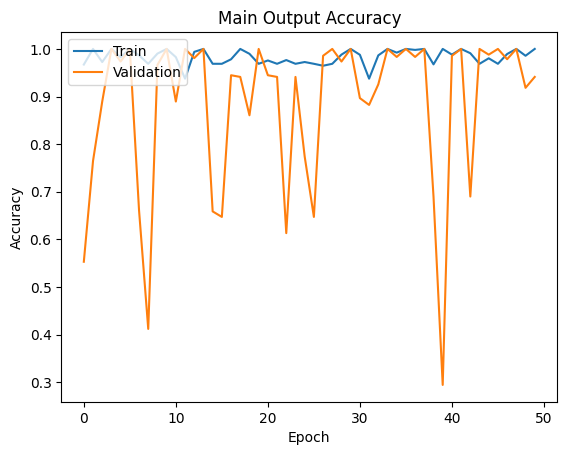

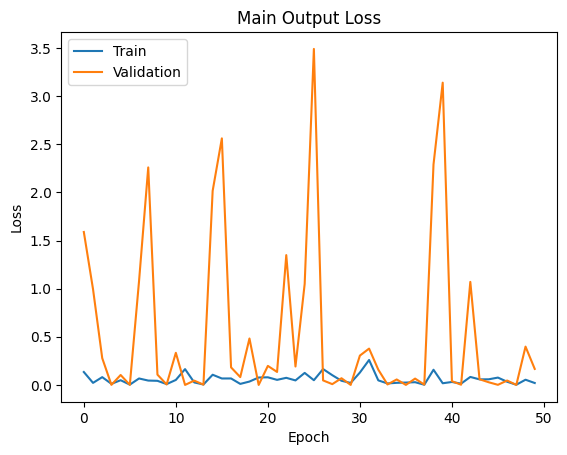

In [56]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values for the main output
plt.plot(history.history['dense_11_accuracy'])  # Change 'dense_1_accuracy' to the actual key of the main output accuracy
plt.plot(history.history['val_dense_11_accuracy'])  # Change 'val_dense_1_accuracy' to the actual key of the main output validation accuracy
plt.title('Main Output Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

"""# Plot training & validation accuracy values for the auxiliary output
plt.plot(history.history['dense_22_accuracy'])  # Change 'dense_2_accuracy' to the actual key of the auxiliary output accuracy
plt.plot(history.history['val_dense_22_accuracy'])  # Change 'val_dense_2_accuracy' to the actual key of the auxiliary output validation accuracy
plt.title('Auxiliary Output Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()"""

# Plot training & validation loss values for the main output
plt.plot(history.history['loss'])  # Change 'loss' to the actual key of the main output loss
plt.plot(history.history['val_loss'])  # Change 'val_loss' to the actual key of the main output validation loss
plt.title('Main Output Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [34]:
history.history

{'dense_11_accuracy': [0.6418890953063965,
  0.78125,
  0.7659137845039368,
  0.8125,
  0.7934291362762451,
  0.84375,
  0.8008213639259338,
  0.65625,
  0.8238192796707153,
  0.78125],
 'loss': [0.6972877383232117,
  0.4214807450771332,
  0.48194563388824463,
  0.40363457798957825,
  0.4067894518375397,
  0.34334176778793335,
  0.38445672392845154,
  0.43319249153137207,
  0.3550921082496643,
  0.3227417469024658],
 'val_dense_11_accuracy': [0.26201921701431274,
  0.0,
  0.26201921701431274,
  0.0,
  0.4038461446762085,
  0.0,
  0.45432692766189575,
  0.0,
  0.49038460850715637,
  0.0],
 'val_loss': [6.888092041015625,
  11.394203186035156,
  17.262561798095703,
  17.14128303527832,
  4.855077743530273,
  9.960358619689941,
  9.444028854370117,
  19.695009231567383,
  11.185606956481934,
  24.044448852539062]}

In [57]:
import numpy as np
from tensorflow.keras.preprocessing import image

# Load the image
img_path = '/kaggle/input/test-images/awake_girl.jpg'
img = image.load_img(img_path, target_size=(299, 299))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Expand dimensions to match batch size

# Preprocess the image
img_array = img_array / 255.0  # Normalize pixel values

# Make predictions
predictions = model.predict(img_array)

# Convert predictions to class labels
class_labels = ['Closed', 'Open', 'no_yawn', 'yawn']
predicted_class_index = np.argmax(predictions[0])  # Assuming main output predictions are stored at index 0
predicted_class = class_labels[predicted_class_index]

print("Predicted class:", predicted_class)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Predicted class: Open


In [60]:

import numpy as np
from tensorflow.keras.preprocessing import image

# Load the image
img_path = '/kaggle/input/test-images/WhatsApp Image 2024-04-01 at 10.49.30 AM.jpeg'
img = image.load_img(img_path, target_size=(299, 299))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Expand dimensions to match batch size

# Preprocess the image
img_array = img_array / 255.0  # Normalize pixel values

# Make predictions
predictions = model.predict(img_array)

# Convert predictions to class labels
class_labels = ['Closed', 'Open', 'no_yawn', 'yawn']
predicted_class_index = np.argmax(predictions[0])  # Assuming main output predictions are stored at index 0
predicted_class = class_labels[predicted_class_index]

print("Predicted class:", predicted_class)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicted class: Open
